In [139]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

In [145]:
# generate dataset

np.random.seed(123)

mu = np.array([50, 80])
sd = np.array([3, 5])

n_samples = np.array([100, 150])
factor_levels = np.array(['A', 'B'])

data = pd.DataFrame(data={
    'y':np.concatenate(
        (np.random.normal(loc=mu[0], scale=sd[0], size=n_samples[0]), 
         np.random.normal(loc=mu[1], scale=sd[1], size=n_samples[1]))),
    'x':np.repeat(factor_levels, n_samples)
})

data.x = pd.Categorical(data.x, ordered=False)

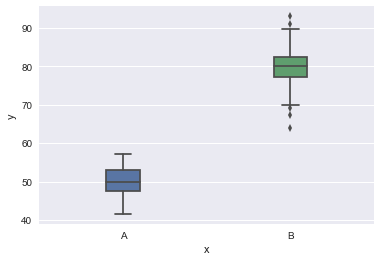

In [148]:
sns.boxplot(x='x', y='y', data=data, width=0.2)

In [45]:
# design matrix. Treatment (Dummy) Coding (see: https://onlinecourses.science.psu.edu/stat502/node/246)
_, X = patsy.dmatrices('y ~ 1 + x', data=data)
X = np.asarray(X)

In [46]:
with pm.Model() as ttest_treatment_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5, shape=(X.shape[1]))
    
    mu = pm.math.dot(X, beta)
    
    # the standard deviation is assumed to be different between groups. If I were to assume that instead the sd is the same
    # then I would see that the ampler would not converge properly
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.x.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=2000, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


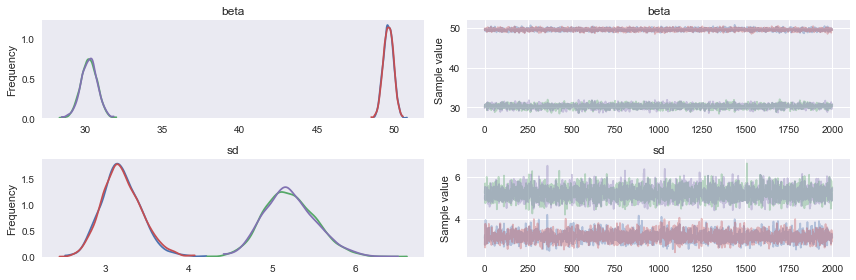

In [47]:
_ = pm.traceplot(trace)

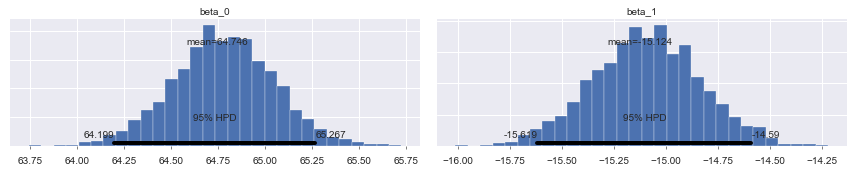

In [138]:
_ = pm.plot_posterior(trace, ['beta'])

In [95]:
# design matrix. ´Effects model´ . The intercept is the grand mean, whereas the slope is the deviations of the factors levels
_, X = patsy.dmatrices('y ~ C(x, Sum)', data=data)
X = np.asarray(X)

In [88]:
with pm.Model() as ttest_sum_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5, shape=(X.shape[1]))
    
    mu = pm.math.dot(X, beta)
    
    # the standard deviation is assumed to be different between groups. If I were to assume that instead the sd is the same
    # then I would see that the ampler would not converge properly
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.x.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=2000, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


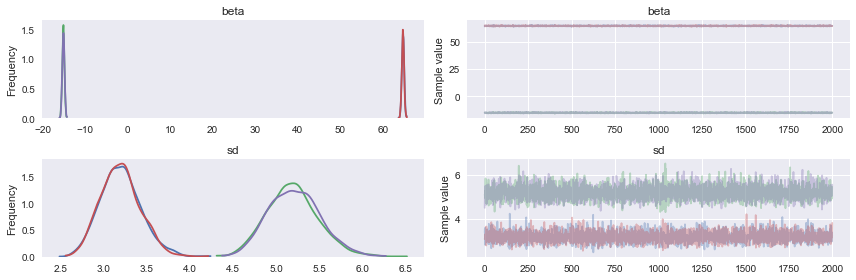

In [89]:
_ = pm.traceplot(trace)

Grand mean = [64.74052179]
Levels mean = 
           y
x           
A  49.616239
B  79.864805


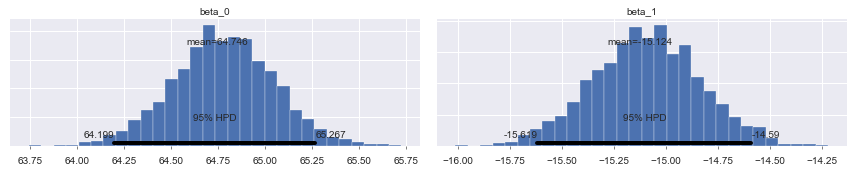

In [137]:
print('Grand mean = {}'.format(data.groupby(by='x').mean().mean().values))
print('Levels mean = ')
print(data.groupby(by='x').mean())

_ = pm.plot_posterior(trace, ['beta'])